<a href="https://colab.research.google.com/github/pyo9912/AI_Study/blob/master/TorchText/NewsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch==1.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.
torchvision 0.15.2+cu118 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.


In [ ]:
!pip install folium==0.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79793 sha256=537cb88abc2e065306c1b47253e9b7e380e985951ff81a4b56b99270f01c2344
  Stored in directory: /root/.cache/pip/wheels/00/0c/07/d7792a5444d5bb074361ac27da53cee9d5cce59a07fe9da5dd
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.14.0
    Uninstalling folium-0.14.0:
      Successfully uninstalled folium-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.17.6 requires folium>=0.9.1, but you have folium 0.2.1 which is incompatible.


In [ ]:
!pip install torchdata==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 37.4 MB/s eta 0:00:00
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.6.1
    Uninstalling torchdata-0.6.1:
      Successfully uninstalled torchdata-0.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.
torchtext 0.15.2 requires torchdata==0.6.1, but you have torchdata 0.4.0 which is incompatible.


In [ ]:
pip install torchtext==0.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.6 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [ ]:
pip install 'portalocker>=2.0.0'

In [ ]:
import torch
from torchtext.datasets import AG_NEWS
train_iter = iter(AG_NEWS(split='train'))

In [ ]:
next(train_iter)

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [ ]:
next(train_iter)

(3,
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')

In [ ]:
next(train_iter)

(3,
 "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")

## 데이터 처리 파이프라인 준비하기
- torchtext 라이브러리는 가공되지 않은 텍스트 문장들을 만드는 (yield) 몇 가지 기초 데이터셋 반복자를 제공.
- 아래는 tokenizer 및 vocab을 사용한 일반적인 NLP 데이터 처리의 예시.
- 첫 번째 단계는 가공되지 않은 train dataset으로 vocab을 만드는 것

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train')

def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

Vocabulary block은 토큰을 정수로 변환

In [ ]:
vocab(['here','is','an','example'])

[475, 21, 30, 5297]

텍스트 처리 파이프라인을 준비

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [ ]:
text_pipeline('here is the an example')

[475, 21, 2, 30, 5297]

In [ ]:
label_pipeline("10")

9

## 데이터 배치 (batch)와 iter 생성하기


In [ ]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

## 모델 정의하기
모델 구성: nn.EmbeddingBag layer + 분류 목적의 linear layer
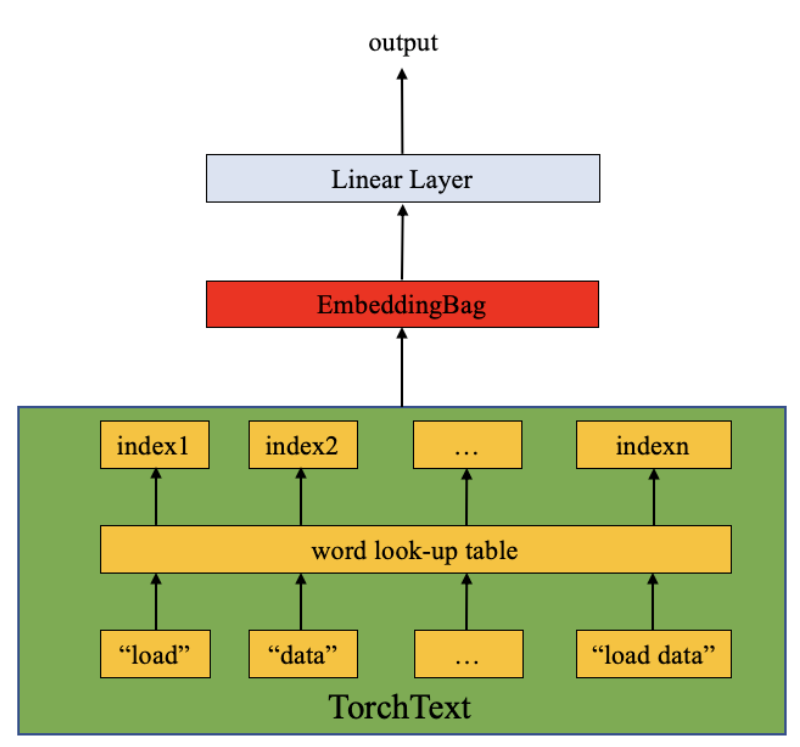

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

## 모델을 학습하고 결과를 평가하는 함수 정의하기

In [ ]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
  model.eval()
  total_acc, total_count = 0, 0

  with torch.no_grad():
    for idx, (label, text, offsets) in enumerate(dataloader):
      predicted_label = model(text, offsets)
      loss = criterion(predicted_label, label)
      total_acc += (predicted_label.argmax(1) == label).sum().item()
      total_count += label.size(0)
    return total_acc/total_count

## 데이터셋을 분할하고 모델 수행하기

In [ ]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 10
LR = 5
BATCH_SIZE = 64

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.685
| epoch   1 |  1000/ 1782 batches | accuracy    0.855
| epoch   1 |  1500/ 1782 batches | accuracy    0.876
-----------------------------------------------------------
| end of epoch   1 | time: 11.03s | valid accuracy    0.874 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.898
| epoch   2 |  1000/ 1782 batches | accuracy    0.900
| epoch   2 |  1500/ 1782 batches | accuracy    0.906
-----------------------------------------------------------
| end of epoch   2 | time:  9.61s | valid accuracy    0.891 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.916
| epoch   3 |  1000/ 1782 batches | accuracy    0.915
| epoch   3 |  1500/ 1782 batches | accuracy    0.918
-----------------------------------------------------------
| end of epoch   3 | time: 10.54s | valid accuracy    0.888 
-------------------------------

In [ ]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.904


In [ ]:
ag_news_label = {
    1: "World",
    2: "Sports",
    3: "Business",
    4: "Sci/Tec"
}

def predict(text, text_pipeline):
  with torch.no_grad():
    text = torch.tensor(text_pipeline(text))
    output = model(text, torch.tensor([0]))
    return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

model = model.to("cpu")

print("This is a %s news" %ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Sports news
